# Tutorial 4: Gaussian Process noise model

**Author:** Hannu Parviainen <br>
**Edited:** 12 September 2025

The previous examples have assumed that the noise in our observations is white, but ExoIris also allows you to model the noise as a Gaussian Process with a freely set kernel. ExoIris uses the Celerite2 package for Gaussian Process calculation. 

In [1]:
%run ../setup_multiprocessing.py

In [2]:
import matplotlib.pyplot as plt

from multiprocessing import Pool
from matplotlib.pyplot import subplots, setp
from exoiris import load_model

plt.rc('figure', figsize=(12,4))

## Load a previous analysis

In [3]:
ts = load_model("01a.fits", name='04a')

## Changing the noise model

The noise model used for the analysis can be changed with the `ExoIris.set_noise_model` method that accepts three options: `white`, `fixed_gp`, or `free_gp`. By default, ExoIris uses a white noise model, but changing to use `fixed_gp` initialises `celerite2.GaussianProcess` with a Matern-3/2 kernel. The "fixed" in the GP noise model comes from the fact that the GP hyperparameters are not included in the model, but the GP kernel and its hyperparameters are instead considered to be fixed in the analysis. The kernel is given default hyperparameters that should be optimised for the data. ExoIris creates a separate GP for each data set in the analysis, which can be accessed as a list from `ExoIris.gp`.

So, let's change to use a fixed GP log likelihood, and take a look at the `ExoIris.gp`.

In [4]:
ts.set_noise_model('fixed_gp')

Now, our analysis consists of two data sets, so we expect `ExoIris.gp` to contain two `GaussianProcess` objects

In [5]:
ts.gp

In [6]:
ts.gp[0].kernel

In [7]:
ts.gp[0].kernel.sigma, ts.gp[0].kernel.rho

(0.009794427656045147, 0.1)

By default, ExoIris sets up a GP with a Matern-3/2 kernel with sigma corresponding to the standard deviation of the out-of-transit flux, and rho of 0.1. **These hyperparameters are almost certainly a very poor choice to represent the noise in your data and should be changed before continuing to the analysis.**

ExoIris offers two utility functions to modify the kernel and its hyperparameters. First, `ExoIris.set_gp_hyperparameters(sigma, rho)` can be used to quickly set the two Matern-3/2 kernel hyperparameters.

In [8]:
ts.set_gp_hyperparameters(sigma=1e-3, rho=0.1)
print(ts.gp[0].kernel, ts.gp[0].kernel.sigma, ts.gp[0].kernel.rho)
print(ts.gp[1].kernel, ts.gp[1].kernel.sigma, ts.gp[1].kernel.rho)

<celerite2.terms.Matern32Term object at 0x1384e3250> 0.001 0.1
<celerite2.terms.Matern32Term object at 0x1384a3950> 0.001 0.1


Second, `ExoIris.set_gp_kernel(celerite2.Term)` can be used to set the GP kernel. This is useful if you want to use a more complex kernel than the basic Matern-3/2.

In [9]:
from celerite2.terms import Matern32Term

ts.set_gp_kernel(Matern32Term(sigma=1e-6, rho=0.8) + Matern32Term(sigma=1e-3, rho=1e-4))
print(ts.gp[0].kernel, ts.gp[0].kernel.terms[0].sigma, ts.gp[0].kernel.terms[0].rho)
print(ts.gp[1].kernel, ts.gp[1].kernel.terms[0].sigma, ts.gp[1].kernel.terms[0].rho)

<celerite2.terms.TermSum object at 0x138677e00> 1e-06 0.8
<celerite2.terms.TermSum object at 0x138677e00> 1e-06 0.8


However, the same effect can be achieved by assigning the kernel directly to the `ExoIris.gp.kernel` attribute.

In [10]:
ts.gp[0].kernel = Matern32Term(sigma=1e-6, rho=0.8) + Matern32Term(sigma=1e-3, rho=1e-4)
ts.gp[1].kernel = Matern32Term(sigma=1e-6, rho=0.8) + Matern32Term(sigma=1e-3, rho=1e-4)
print(ts.gp[0].kernel, ts.gp[0].kernel.terms[0].sigma, ts.gp[0].kernel.terms[0].rho)
print(ts.gp[1].kernel, ts.gp[1].kernel.terms[0].sigma, ts.gp[1].kernel.terms[0].rho)

<celerite2.terms.TermSum object at 0x109f765d0> 1e-06 0.8
<celerite2.terms.TermSum object at 0x1384e3250> 1e-06 0.8


## Optimising Matern-3/2 hyperparameters to the data set

The `ExoIris.optimize_gp_hyperparameters` method can be used to optimise a Matern-3/2 kernel to the out-of-transit data. The method can be used without any arguments, but the optimisation can be fine tuned with optional arguments:

- **log10_sigma_bounds**: Either the bounds for log$_{10}$ sigma as a tuple of two floats or a single float to fix the parameter to the given value.
- **log10_rho_bounds**: Either the bounds for log$_{10}$ rho as a tuple of two floats or a single float to fix the parameter to the given value.
- **log10_sigma_prior**: The prior distribution for log$_{10}$ sigma as an object with a `logpdf` method or as an iterable containing the mean and standard deviation of a normal distribution.
- **log10_rho_prior**: The prior distribution for log$_{10}$ rho as an object with a `logpdf` method or as an iterable containing the mean and standard deviation of a normal distribution. 
- **subset**: The subset used data to use for the optimization. The method uses all the data by default, but a subset can be chosen by either giving a single float specifying the fraction of the spectroscopic light curves to use, or an iterable containing the integer indices of the light curves to use.
- **npop**: The population size for the differential evolution optimiser.
- **niter** : The number of iterations for the differential evolution optimisation process.

**Noe:** the method will overwrite any existing GP kernel with a Matern-3/2 kernel with optimised hyperparameters.

In [11]:
ts.optimize_gp_hyperparameters()

[array([0.00025697, 0.00025959]), array([0.0001684 , 0.00033387])]

In [12]:
print(ts.gp[0].kernel, ts.gp[0].kernel.terms[0].sigma, ts.gp[0].kernel.terms[0].rho)
print(ts.gp[1].kernel, ts.gp[1].kernel.terms[0].sigma, ts.gp[1].kernel.terms[0].rho)

<celerite2.terms.Matern32Term object at 0x138e87e90> 0.00025697312902007367 0.00025958611047606684
<celerite2.terms.Matern32Term object at 0x138e0f470> 0.00016840265075695112 0.0003338676819576024


## Model optimisation and posterior sampling

Let's first plot the posterior model for the loaded white-noise analysis.

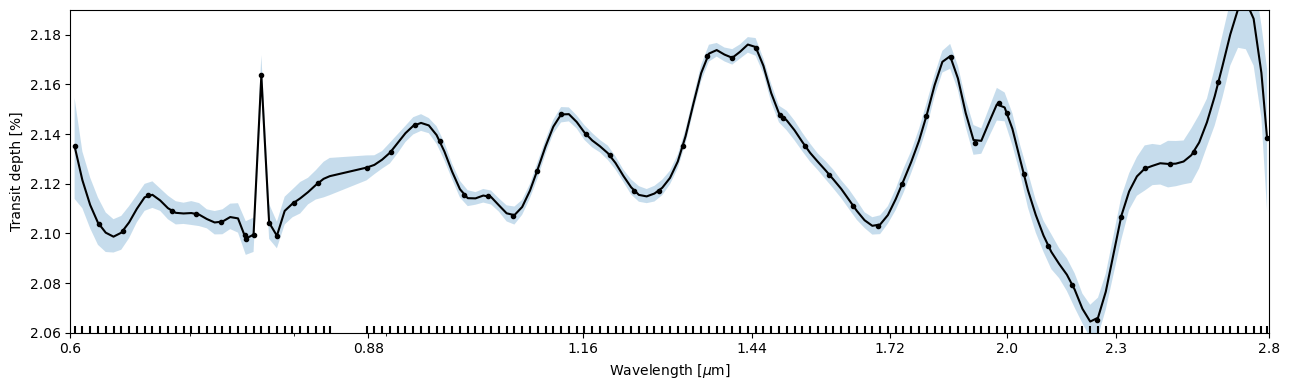

In [13]:
pargs = dict(xscale='log', ylim=(2.0, 2.25), xticks=[0.6, 0.88, 1.16, 1.44, 1.72, 2.0, 2.30, 2.8])

fig, ax = subplots(figsize=(13,4))
ts.plot_transmission_spectrum('mcmc', ax=ax, **pargs);
fig.tight_layout()

Then, we can again do a quick DE optimisation before moving to sample the posterior. In this example, the optimisation finishes immediately because the GP log likelihood is very similar to the white noise assumtion.

In [14]:
def lnpostf(pv):
    return ts.lnposterior(pv)

pool = Pool(8)

In [15]:
pvp0 = ts.create_initial_population(250, 'mcmc', False)

Global optimisation:   0%|          | 0/1500 [00:00<?, ?it/s]

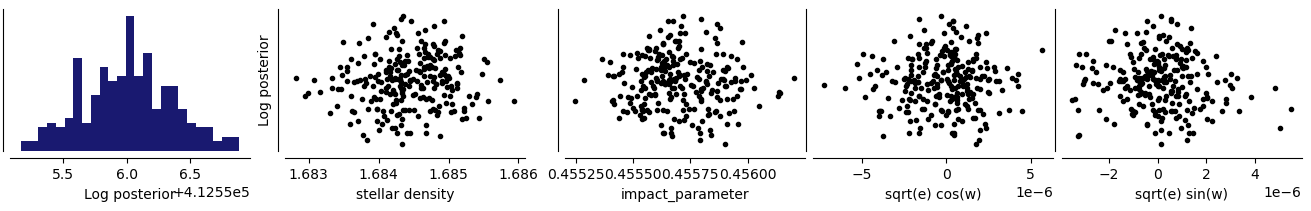

In [16]:
ts.fit(niter=1500, initial_population=pvp0, pool=pool, lnpost=lnpostf)

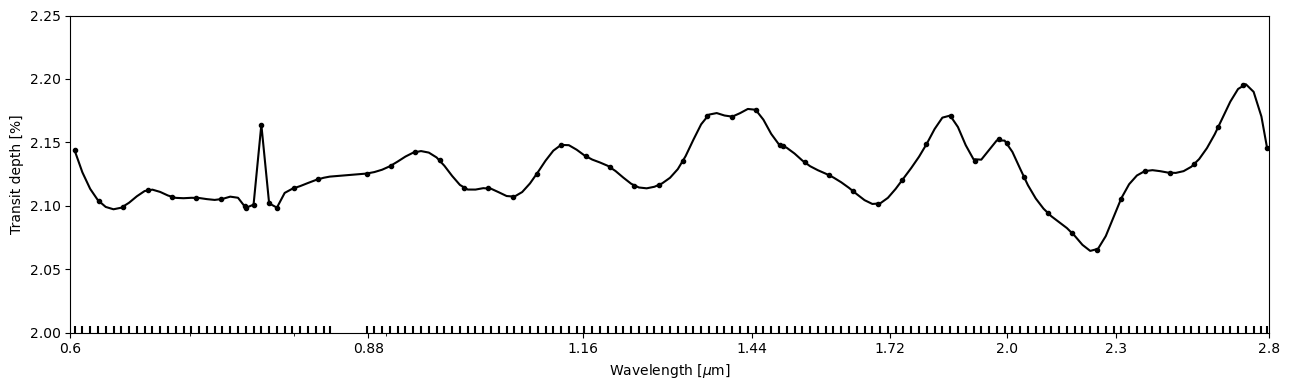

In [24]:
fig, ax = subplots(figsize=(13,4))
ts.plot_transmission_spectrum('fit', ax=ax, **pargs);
fig.tight_layout()

In [18]:
ts.reset_sampler()

In [19]:
ts.sample(1000, thin=100, repeats=2, pool=pool, lnpost=lnpostf)

MCMC sampling:   0%|          | 0/2 [00:00<?, ?it/s]

Run 1/2:   0%|          | 0/1000 [00:00<?, ?it/s]

Run 2/2:   0%|          | 0/1000 [00:00<?, ?it/s]

And now we can plot the GP posterior model. In this example case, changing the noise model led to slightly larger posterior uncertainties, but the differences aren't great.

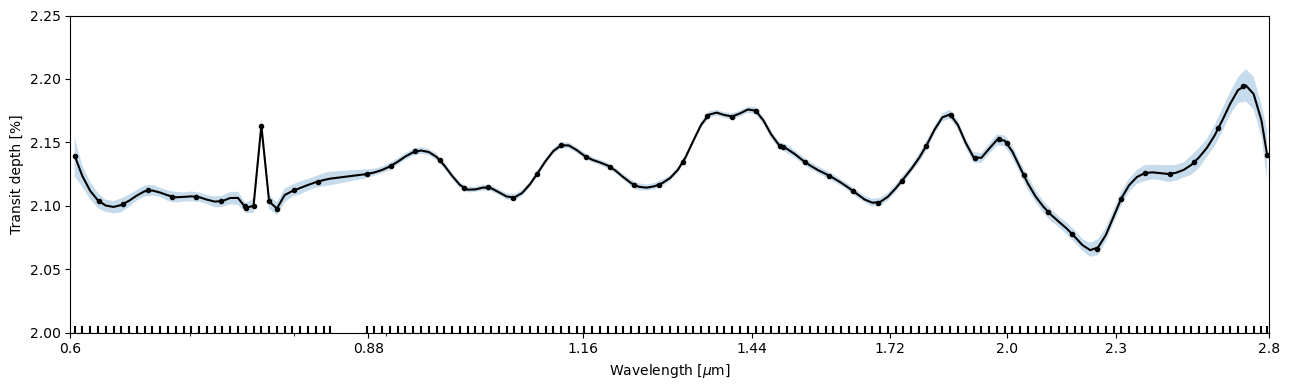

In [23]:
fig, ax = subplots(figsize=(13,4))
ts.plot_transmission_spectrum('mcmc', ax=ax, **pargs);
fig.tight_layout()

In [ ]:
ts.save()

---

<center>&copy;2025 Hannu Parviainen</center>